In [1]:
# change current directory
import os
import sys

module_path = os.path.abspath(os.path.join('')) # To import helpers
if module_path not in sys.path:
    sys.path.append(module_path+"/pypsa-earth/scripts")
    
print(module_path)

/home/raj08555/dev/thesis-notebook/analysis


A jupyter notebook requires the user to import all they need. So we need to import all the required dependencies from the `pypsa-africa` environment:

In [2]:
import atlite
import cartopy.crs as ccrs
import cartopy
import xarray as xr
import geopandas as gpd

# import holoviews as hv
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import requests
import pypsa
import shutil
from rasterio.plot import show
from atlite.gis import shape_availability, ExclusionContainer

import shapely
import warnings
from shapely.errors import ShapelyDeprecationWarning
warnings.filterwarnings("ignore", category=ShapelyDeprecationWarning) # Ignore Shapely warnings

plt.rcParams["figure.figsize"] = [7, 7]
%matplotlib inline

## Generate profiles (if not already available)

If you don't have the renewable profiles such as:
- `resources/profile_solar.nc`
- `resources/profile_onwind.nc`
- `resources/profile_offwind-ac.nc`

you could try to generate them from the terminal. In this case set the path so that you are located at ~/pypsa-africa. Once you are there, use the command:

```
snakemake -j 1 resources/profile_{technology}.nc
```

replace {technology} for the timeseries of interest.

## Let's open the profiles
The `build_renewable_profiles` for each technology are stored in the `resources` folder. We read first the path and open then with xarray the .nc file. As you can see there is quite a lot data available.  What you should note is that only the `potential` is grided (can be shown in a nice raster on a map). From the `profiles` we can only retrieve timeseries data without mapping it.

In [153]:
# #solar_path = os.path.realpath("pypsa-earth") + "/resources/renewable_profiles/profile_solar.nc"
# solar = xr.open_dataset("C:/Users/raj08555/Dev/thesis-notebook/resources/renewable_profiles/profile_solar.nc")
# #wind_path = os.path.realpath("pypsa-earth") + "/resources/renewable_profiles/profile_onwind.nc"
# wind = xr.open_dataset("C:/Users/raj08555/Dev/thesis-notebook/resources/renewable_profiles/profile_onwind.nc")
# wind
# #C:\Users\raj08555\Dev\thesis-notebook\resources\renewable_profiles\profile_solar.nc

In [3]:
shape_loc = gpd.read_file("/home/raj08555/dev/sandbox-cs/pypsa-earth-sec/pypsa-earth/resources/bus_regions/regions_onshore_elec_s_30.geojson")
elec = pypsa.Network("/home/raj08555/dev/sandbox-cs/pypsa-earth-sec/results/MT_real30/prenetworks/elec_s_30_ec_lc1.0_Co2L_3H_2030_0.082_AP.nc")
#secnet = pypsa.Network("/home/raj08555/dev/sandbox0405/pypsa-earth-sec/results/GADM_opt30/postnetworks/elec_s_30_ec_lc1.0_Co2L_3H_2030_0.076_NZ_0export.nc")
#water_cost = "/home/raj08555/dev/sandbox0405/pypsa-earth-sec/resources/custom_data/NA_water_costs.csv"

INFO:pypsa.io:Imported network elec_s_30_ec_lc1.0_Co2L_3H_2030_0.082_AP.nc has buses, carriers, generators, global_constraints, lines, links, loads, stores


In [45]:
n=elec.copy()
x = n.generators_t.p_max_pu.filter(regex=" solar$").sum()
x
# var = elec.links.marginal_cost.filter(like='lectrolysis')
# var = var.rename(index=lambda x: x.split(" ", 1)[0])
# var

Generator
NAM10_AC solar    617.289989
NAM11_AC solar    613.676655
NAM12_AC solar    625.856680
NAM13_AC solar    603.963332
NAM14_AC solar    604.906670
NAM15_AC solar    606.260004
NAM16_AC solar    599.270006
NAM17_AC solar    576.640000
NAM18_AC solar    599.093339
NAM19_AC solar    608.940004
NAM1_AC solar     498.753337
NAM20_AC solar      0.000000
NAM22_AC solar    587.140009
NAM23_AC solar    600.353327
NAM24_AC solar    601.223354
NAM25_AC solar    595.390003
NAM26_AC solar    568.699122
NAM27_AC solar    560.146669
NAM28_AC solar    589.269993
NAM29_AC solar    604.476668
NAM2_AC solar     520.266351
NAM30_AC solar    604.313335
NAM3_AC solar     539.093648
NAM4_AC solar     558.596663
NAM5_AC solar     553.486671
NAM6_AC solar     521.200852
NAM7_AC solar     532.355057
NAM8_AC solar     491.469997
NAM9_AC solar     586.240960
dtype: float64

In [52]:
def plot_potential(n, carrier, shape, cmap, projection, title=None, filename=None):
    g = n.generators.loc[n.generators.carrier == carrier]
    shp = shape.set_index("name")
    
    shp_area = shp.to_crs("epsg:4326").geometry.area * 1e-6
    #shp_area = shp_area.geometry.area * 1e-6
    shp["p_nom_max"] = g.groupby("bus").sum().p_nom_max / shp_area
    
    var = n.generators_t.p_max_pu.filter(regex="{}$".format(carrier)).sum()*3
    var = var.rename(index=lambda x: x.split(" ", 1)[0])
    shp["p_max_pu"] = var
    
    print(shp["p_max_pu"])
    fig, ax = plt.subplots(figsize=(8, 5), dpi=300, subplot_kw={"projection": projection})
    plt.rcParams.update({"font.size": 10})
    shp.plot(
        ax=ax,
        column="p_max_pu",
        transform=ccrs.PlateCarree(),
        linewidth=0.25,
        edgecolor="k",
        cmap=cmap,
        vmin=0,
        vmax= shp["p_max_pu"].max(),
        legend=True,
        legend_kwds={"label": "full load hours (Hrs)"},
    )
    ax.coastlines()
    #ax.add_feature(cartopy.feature.BORDERS.with_scale("110m"))
    #ax.set_extent([2, 14.5, 3, 14], crs=ccrs.PlateCarree())  # Nigeria
    # ax.set_extent([-23, 55, -35, 40], crs=ccrs.PlateCarree())  # Africa
    ax.set_extent(shp.total_bounds[[0, 2, 1, 3]])  # Namibia

    if title is not None:
        plt.title(title)

    if filename is not None:
        plt.savefig(filename, bbox_inches="tight")

    #print(shp)

/tmp/ipykernel_574681/3408083108.py:5: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  shp_area = shp.to_crs("epsg:4326").geometry.area * 1e-6


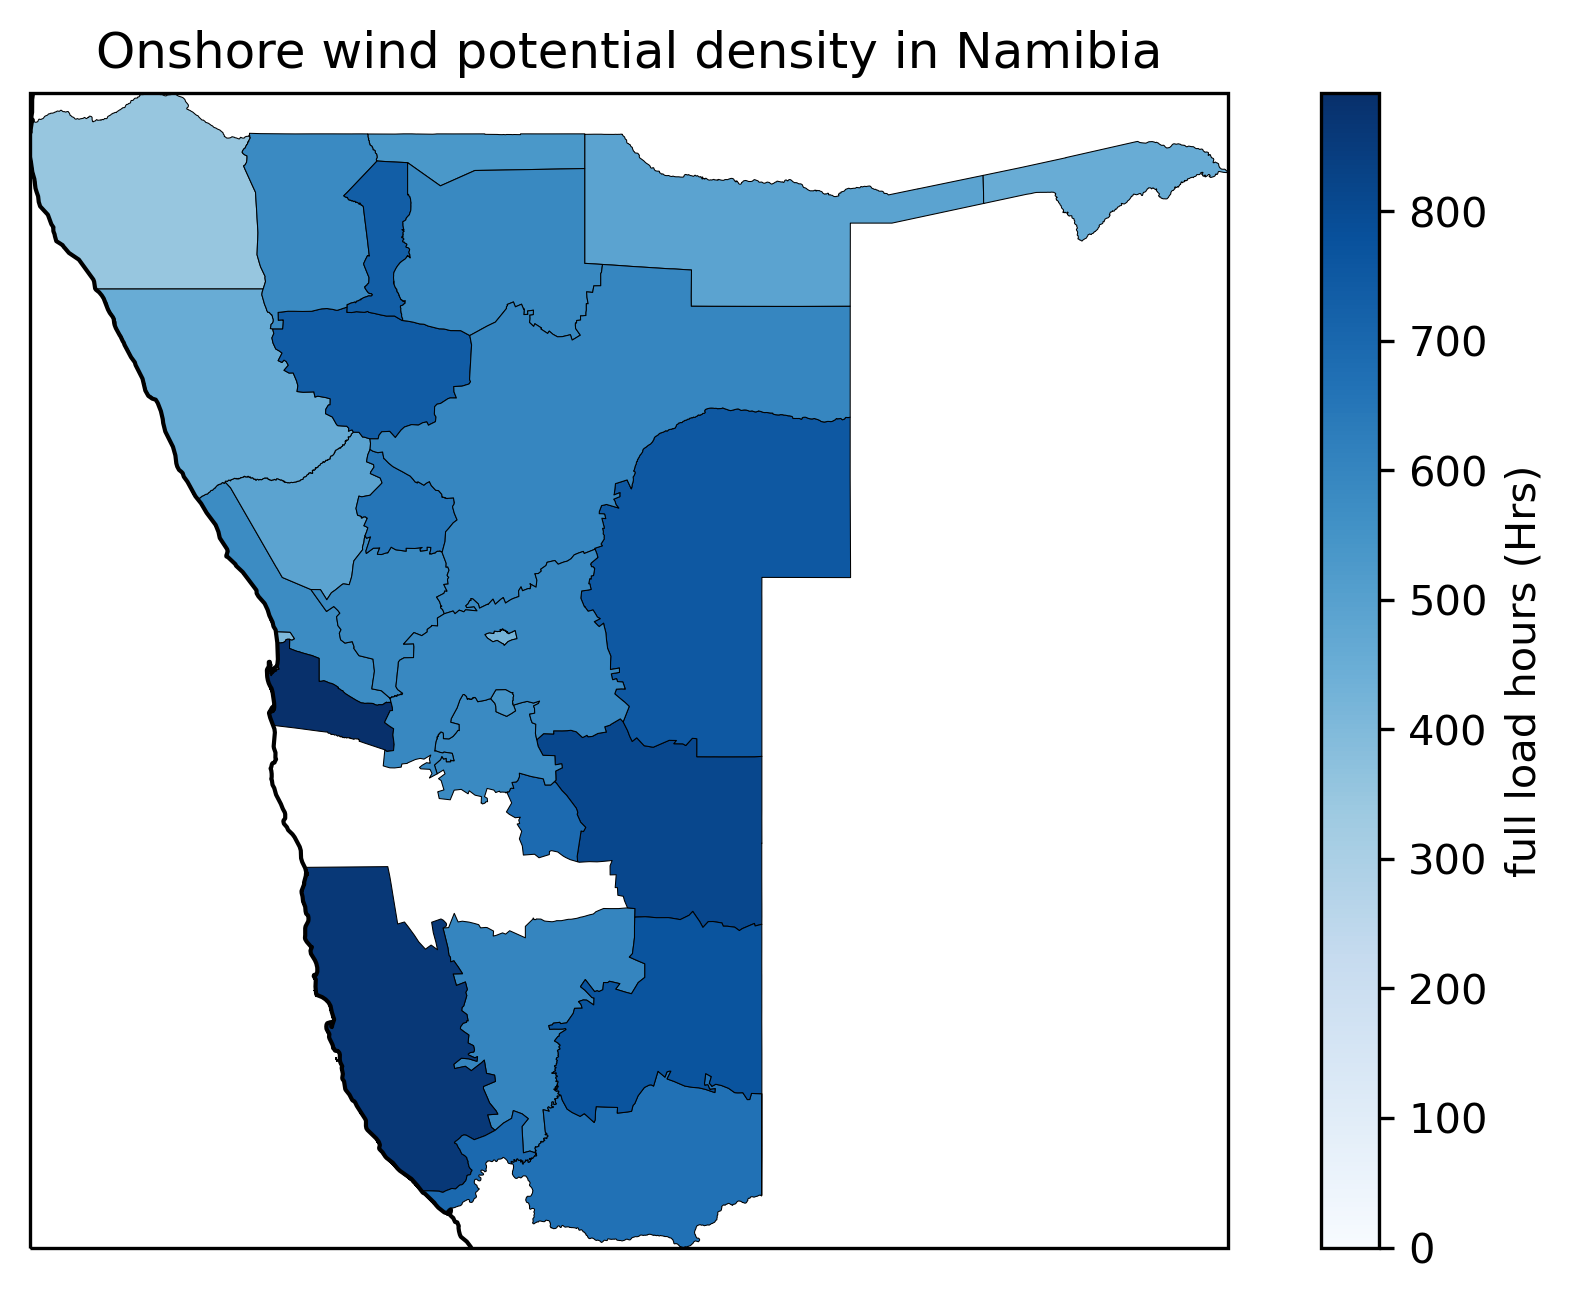

In [41]:
plot_potential(
    elec,
    "onwind",
    shape_loc,
    "Blues",
    ccrs.PlateCarree(),
    title="Onshore wind potential density in Namibia",
    # filename="onwind-cell.pdf",
)

/tmp/ipykernel_574681/3408083108.py:5: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  shp_area = shp.to_crs("epsg:4326").geometry.area * 1e-6


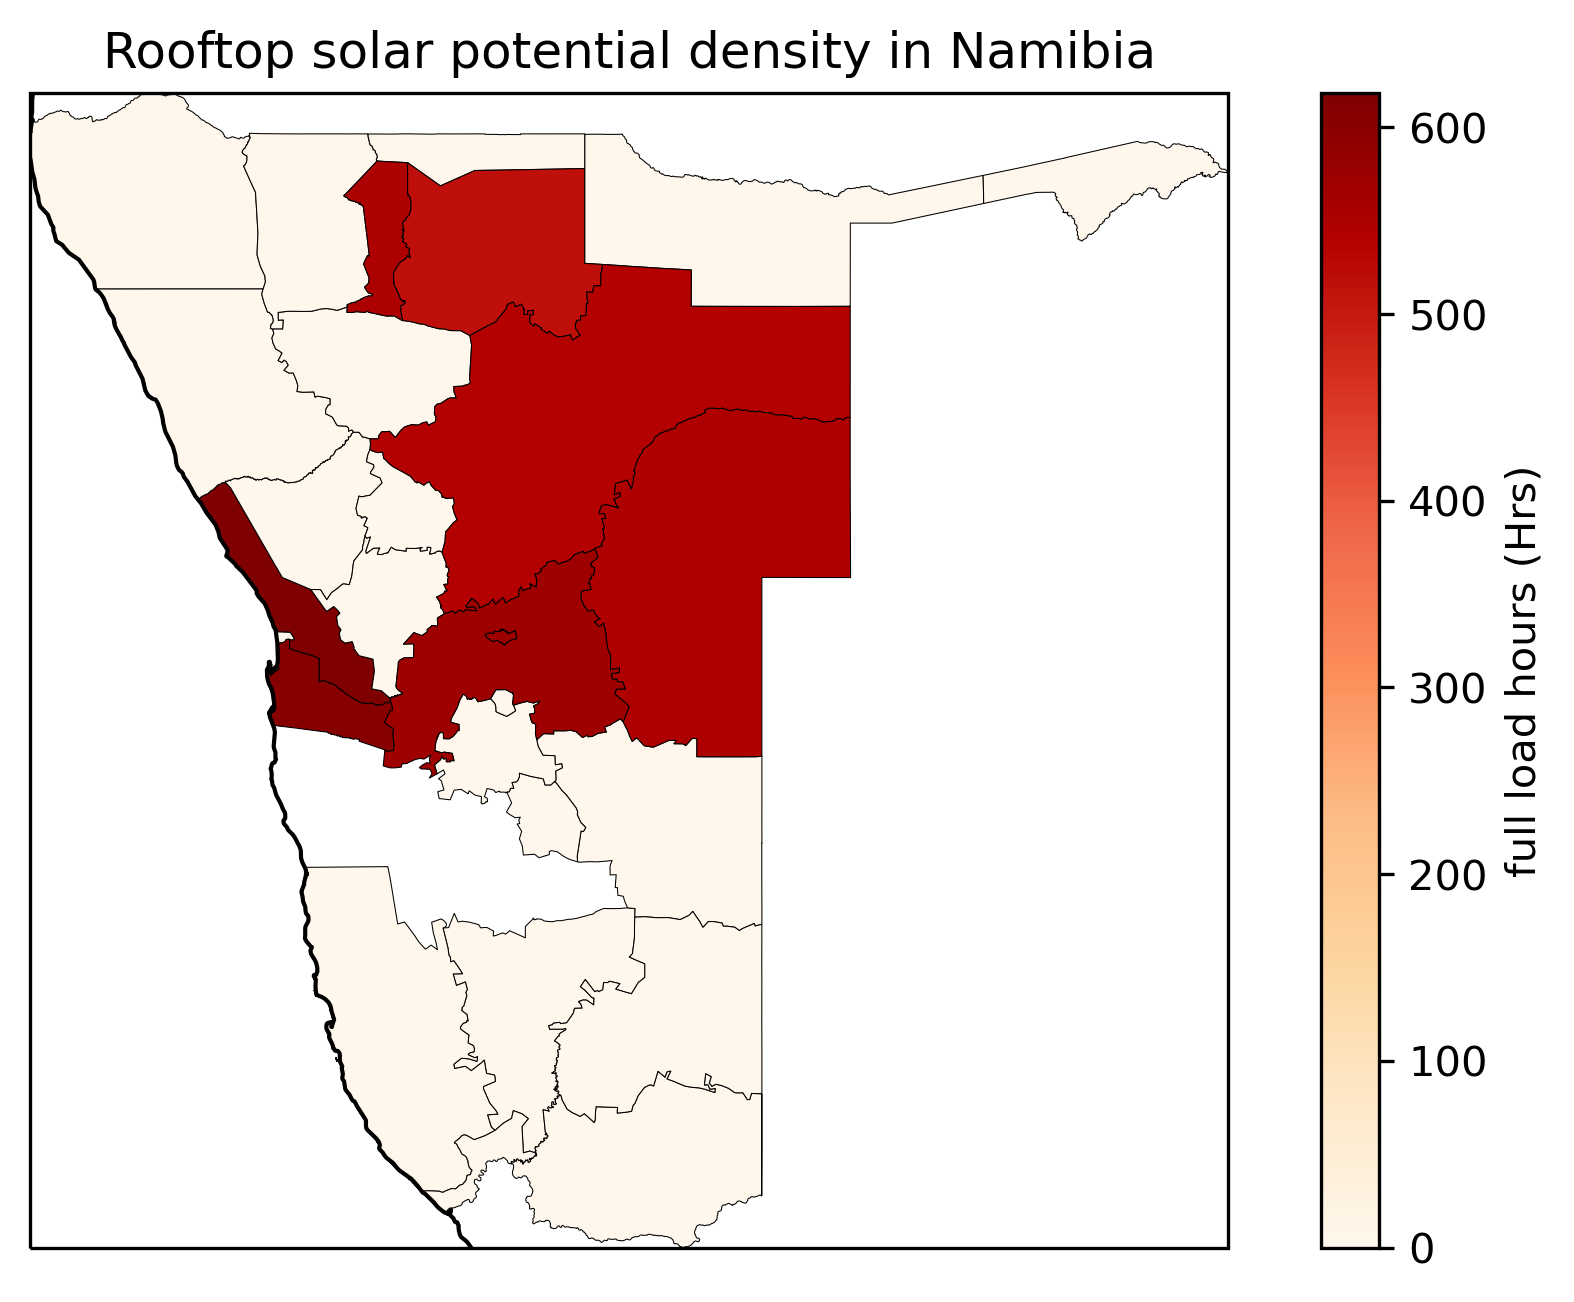

In [42]:
plot_potential(
    elec,
    "rooftop-solar",
    shape_loc,
    "OrRd",
    ccrs.PlateCarree(),
    title="Rooftop solar potential density in Namibia",
    # filename="solar-cell.pdf",
)

/tmp/ipykernel_574681/3348305872.py:5: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  shp_area = shp.to_crs("epsg:4326").geometry.area * 1e-6


name
NAM10_AC    1851.869967
NAM11_AC    1841.029964
NAM12_AC    1877.570039
NAM13_AC    1811.889996
NAM14_AC    1814.720010
NAM15_AC    1818.780013
NAM16_AC    1797.810017
NAM17_AC    1729.919999
NAM18_AC    1797.280018
NAM19_AC    1826.820011
NAM1_AC     1496.260010
NAM20_AC       0.000000
NAM22_AC    1761.420026
NAM23_AC    1801.059980
NAM24_AC    1803.670061
NAM25_AC    1786.170009
NAM26_AC    1706.097365
NAM27_AC    1680.440006
NAM28_AC    1767.809979
NAM29_AC    1813.430003
NAM2_AC     1560.799054
NAM30_AC    1812.940006
NAM3_AC     1617.280944
NAM4_AC     1675.789989
NAM5_AC     1660.460014
NAM6_AC     1563.602557
NAM7_AC     1597.065171
NAM8_AC     1474.409991
NAM9_AC     1758.722880
Name: p_max_pu, dtype: float64


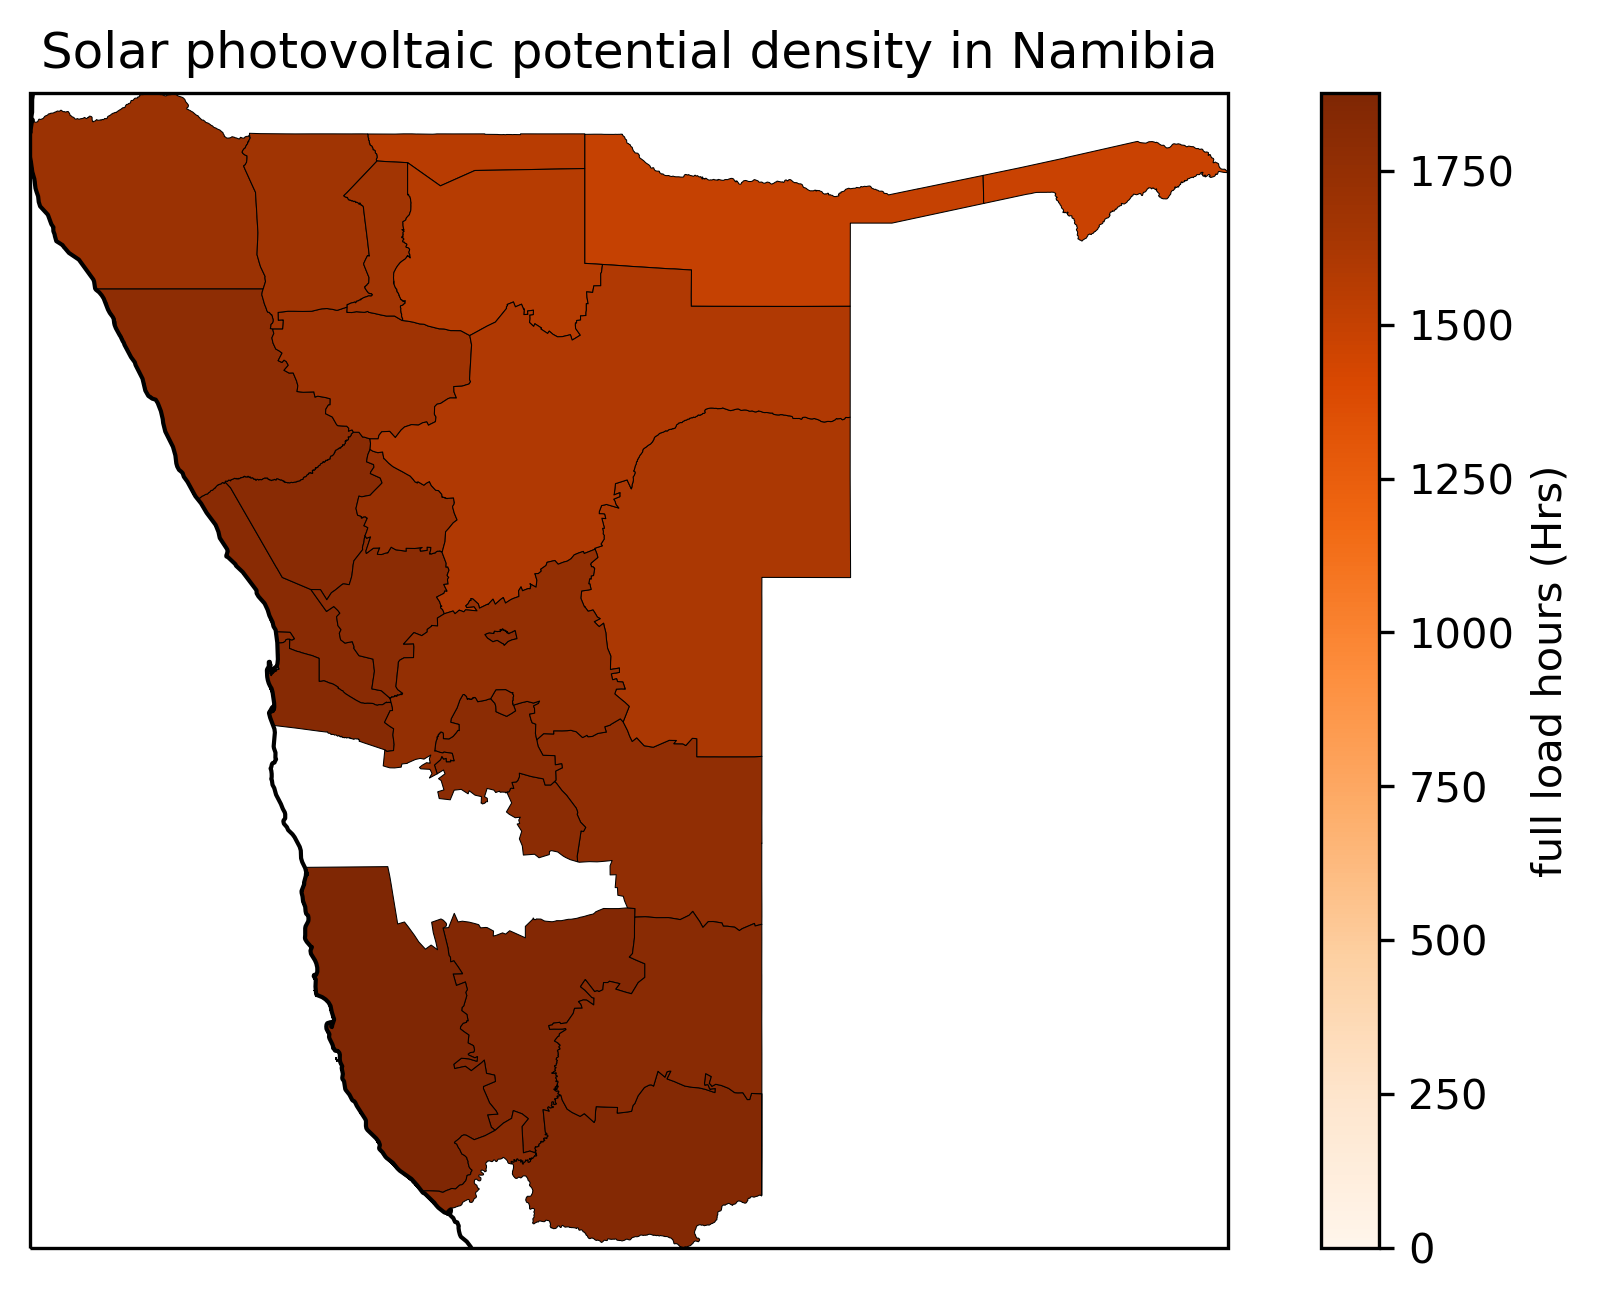

In [53]:
plot_potential(
    elec,
    " solar",
    shape_loc,
    "Oranges",
    ccrs.PlateCarree(),
    title="Solar photovoltaic potential density in Namibia",
    # filename="solar-cell.pdf",
)

/tmp/ipykernel_574681/3408083108.py:5: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  shp_area = shp.to_crs("epsg:4326").geometry.area * 1e-6


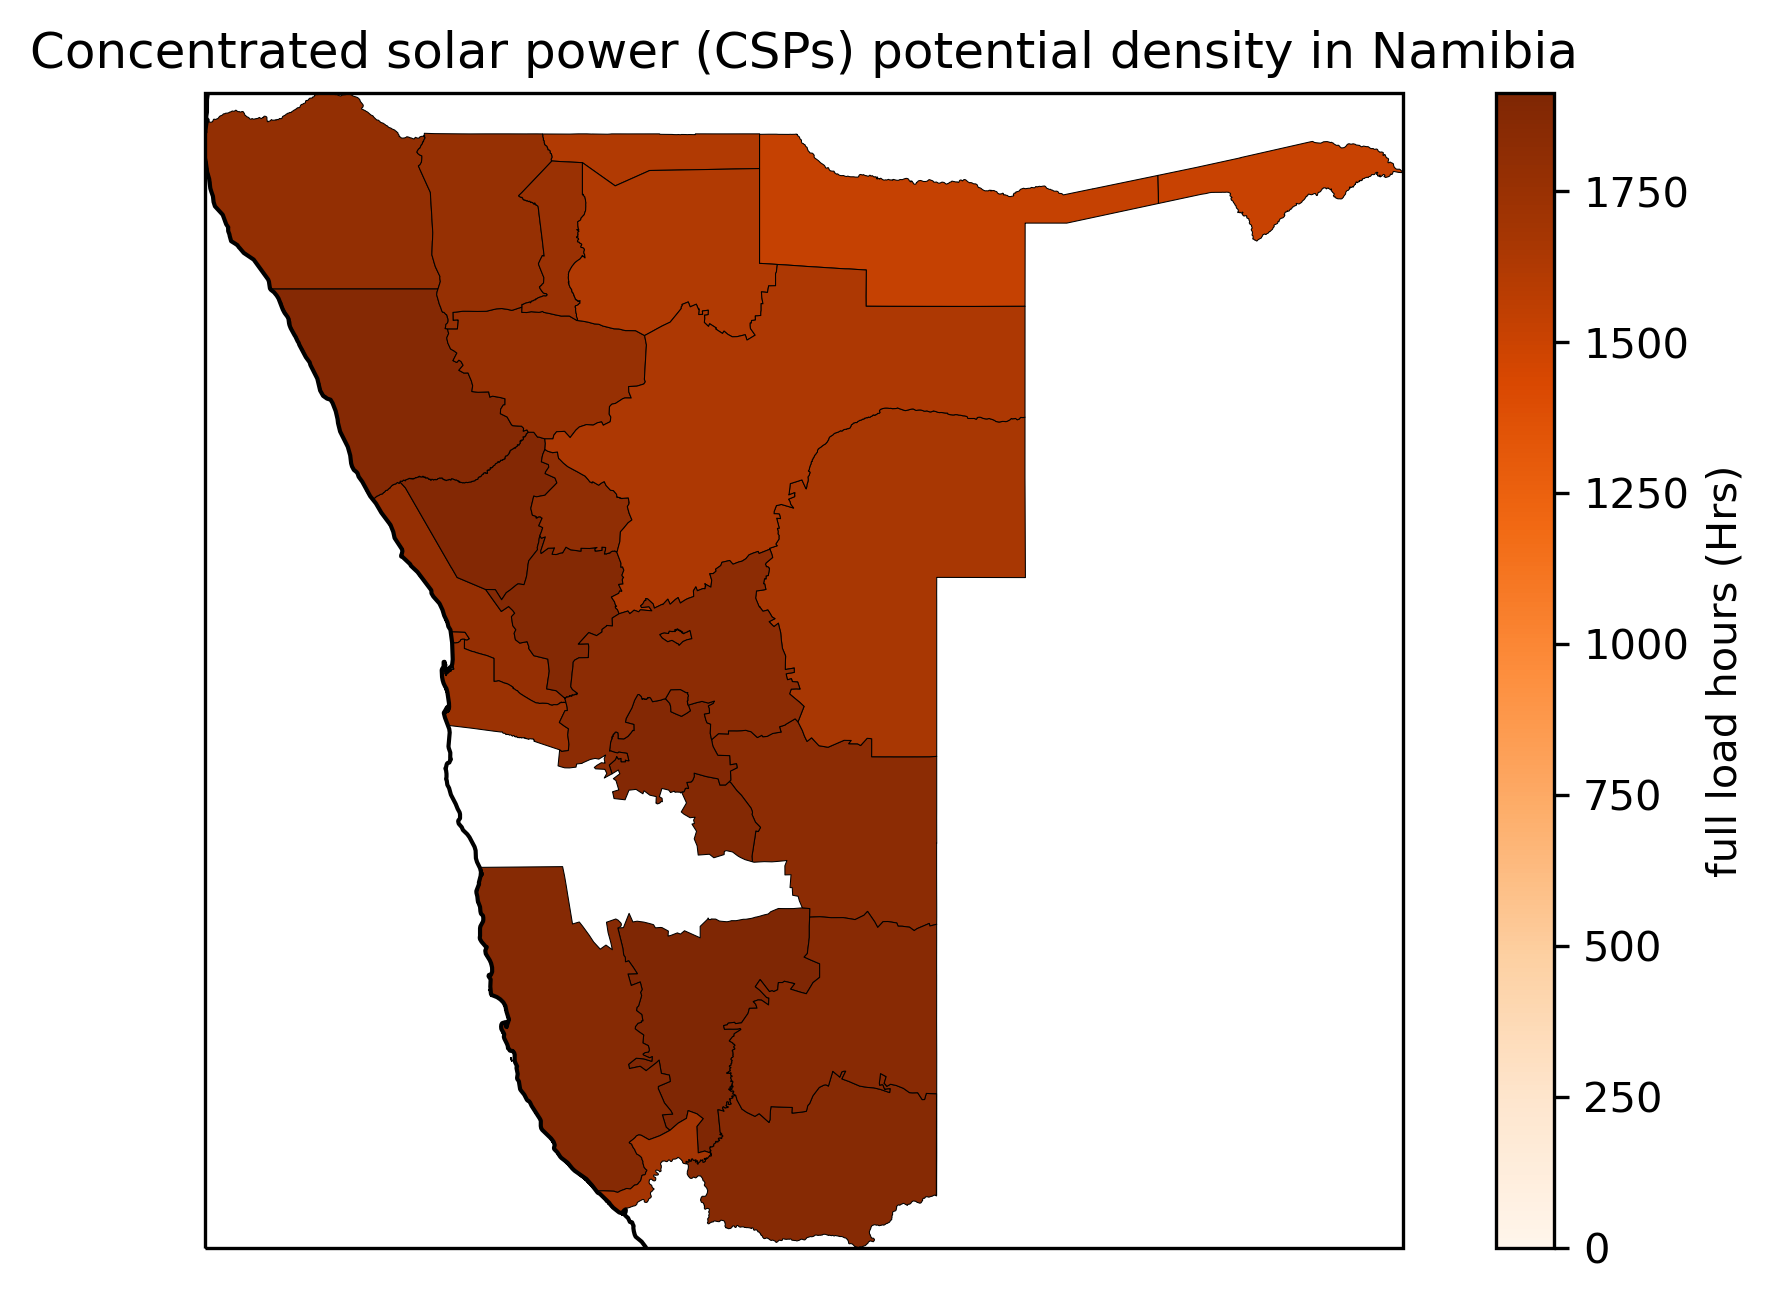

In [48]:
plot_potential(
    elec,
    "csp",
    shape_loc,
    "Oranges",
    ccrs.PlateCarree(),
    title="Concentrated solar power (CSPs) potential density in Namibia",
    # filename="solar-cell.pdf",
)

/tmp/ipykernel_2504557/222309770.py:6: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  shp_area = shp_area.geometry.area * 1e-6


Text(0.5, 1.0, 'water cost for hydrogen production in Namibia')

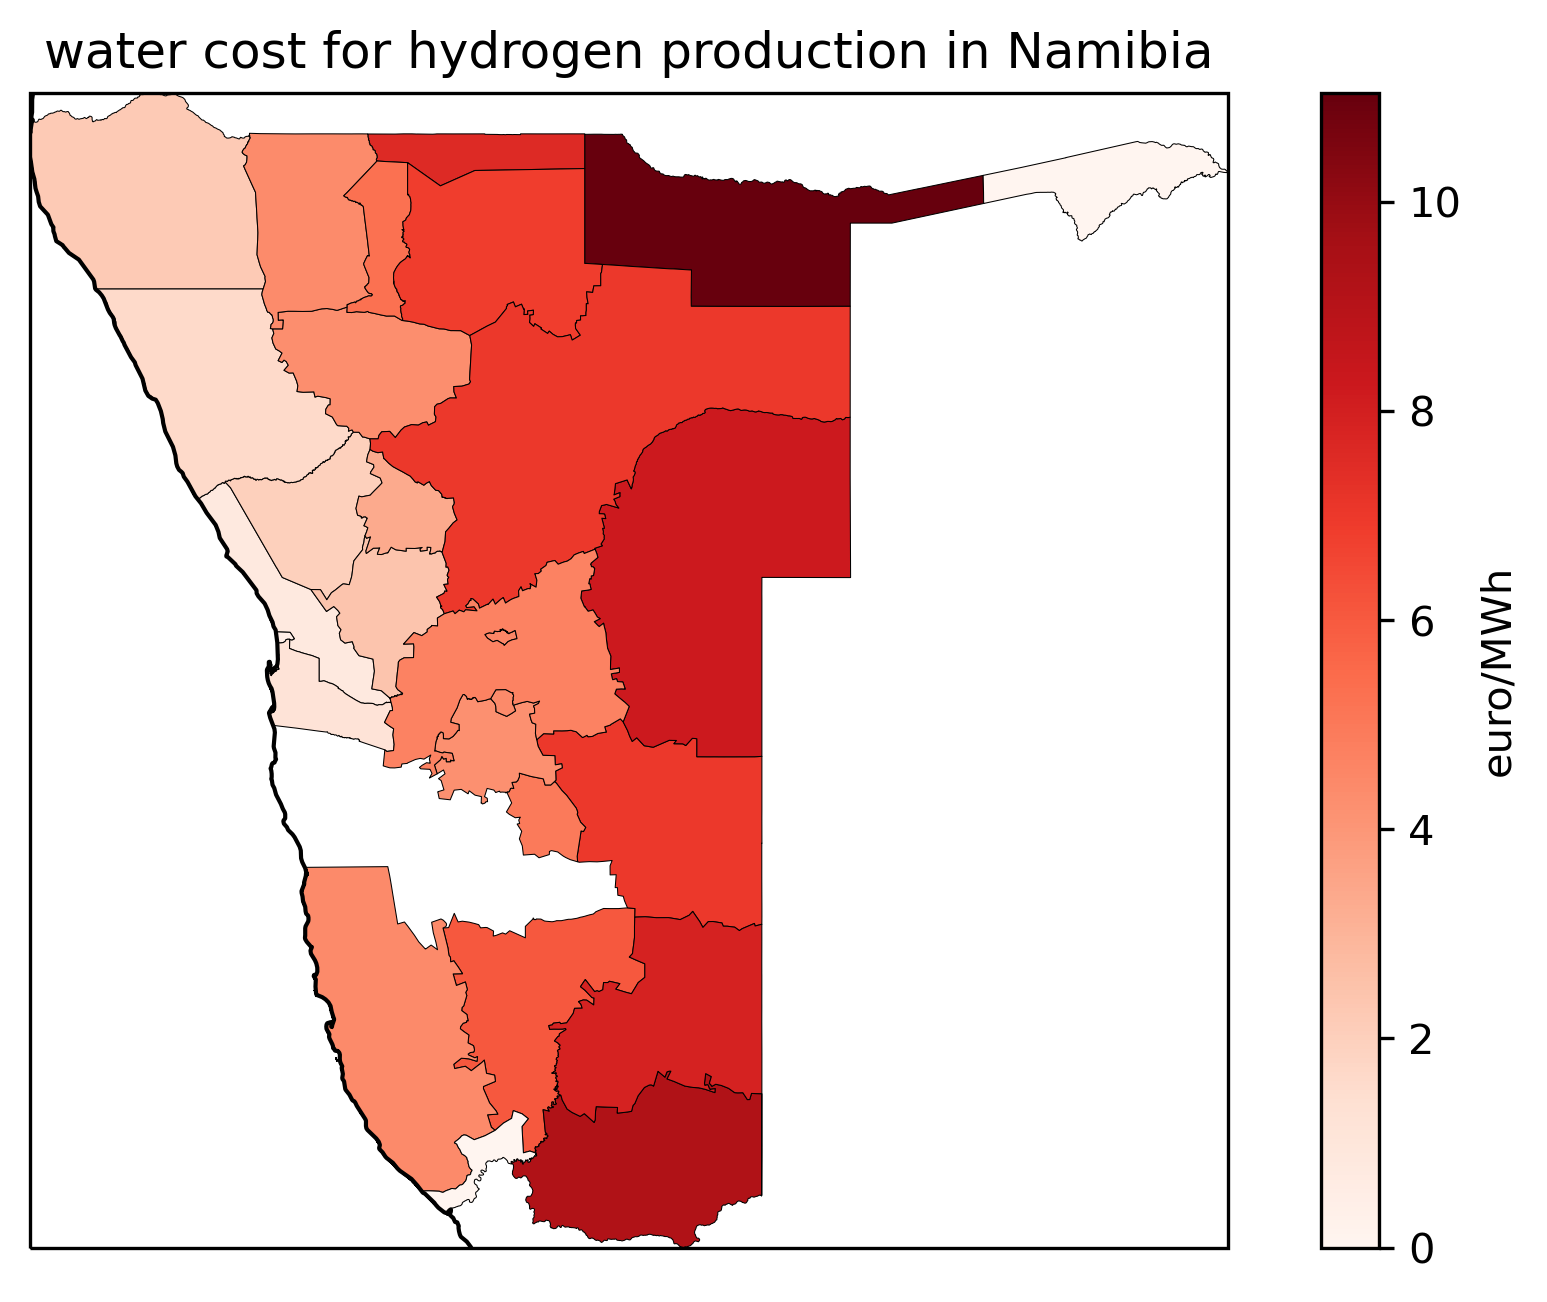

In [167]:
li =[]
water_cost = elec.links.marginal_cost.filter(like='lectrolysis')
elec.links.marginal_cost.filter(like='lectrolysis')
shp = shape_loc.set_index("name")
shp_area = shp.to_crs("epsg:4326")
shp_area = shp_area.geometry.area * 1e-6

var = elec.links.marginal_cost.filter(like='lectrolysis')
shp["water_cost"] = var.rename(index=lambda x: x.split(" ", 1)[0])

fig, ax = plt.subplots(figsize=(8, 5),dpi= 300, subplot_kw={"projection": ccrs.PlateCarree()})
plt.rcParams.update({"font.size": 10})
shp.plot(
    ax=ax,
    column="water_cost",
    transform=ccrs.PlateCarree(),
    linewidth=0.25,
    edgecolor="k",
    cmap='Reds',
    vmin=0,
    vmax=shp["water_cost"].max(),
    legend=True,
    legend_kwds={"label": r"euro/MWh"},
)
ax.coastlines()
#ax.add_feature(cartopy.feature.BORDERS.with_scale("110m"))
#ax.set_extent([2, 14.5, 3, 14], crs=ccrs.PlateCarree())  # Nigeria
# ax.set_extent([-23, 55, -35, 40], crs=ccrs.PlateCarree())  # Africa
ax.set_extent(shp.total_bounds[[0, 2, 1, 3]])  # Namibia

plt.title("water cost for hydrogen production in Namibia")

### Technical 'resource' energy potential [TWh]

In [160]:
technical_solar_potential_twh = (
    sum(solar["p_nom_max"] * solar["profile"]).sum() / 10**6
)  # MWh to TWH conversion
technical_wind_potential_twh = (
    sum(wind["p_nom_max"] * wind["profile"]).sum() / 10**6
)  # MWh to TWH conversion

print(
    f"Technical solar potential: {technical_solar_potential_twh.values} \n",
    f"Technical wind potential: {technical_wind_potential_twh.values}",
)

NameError: name 'solar' is not defined

## Timeseries
Timeseris plots are helpful to analyse the seasonality and general variability. Below we show how you could plot some of these.

Text(0.5, 1.0, '')

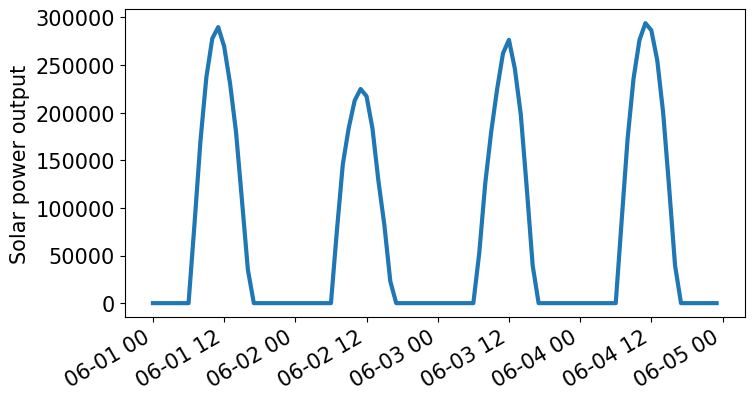

In [ ]:
plt.rcParams.update({"font.size": 15})
fig, ax = plt.subplots(figsize=(8, 4))

# max_installable_capacity [MX] * profiles [p.u.]
solar_profile_mw = solar["p_nom_max"] * solar["profile"]

solar_profile_mw.sel(bus="0", time=slice("2013-06-01", "2013-06-04")).plot(
    ax=ax, linewidth=3
)
ax.set_xlabel(None)
ax.set_ylabel("Solar power output")
ax.set_title(None)

# plt.savefig("solar-power-profile.pdf", bbox_inches="tight")

Text(0.5, 1.0, '')

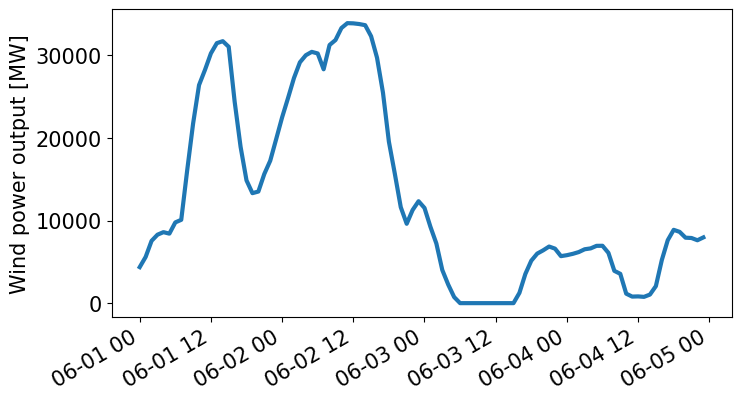

In [ ]:
plt.rcParams.update({"font.size": 15})
fig, ax = plt.subplots(figsize=(8, 4))

# max_installable_capacity [MX] * profiles [p.u.]
wind_profile_mw = wind["p_nom_max"] * wind["profile"]

wind_profile_mw.sel(bus="5", time=slice("2013-06-01", "2013-06-04")).plot(
    ax=ax, linewidth=3
)
ax.set_xlabel(None)
ax.set_ylabel("Wind power output [MW]")
ax.set_title(None)

# plt.savefig("onshore-wind-power-profile.pdf", bbox_inches="tight")

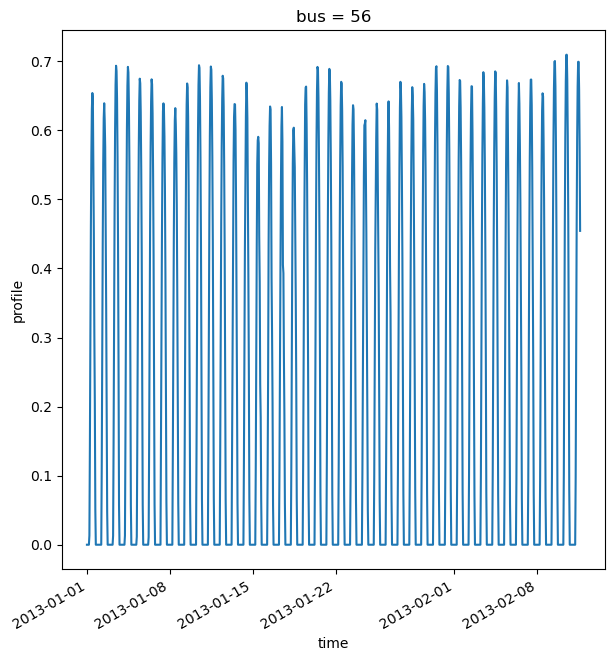

In [ ]:
plt.rcParams.update({"font.size": 10})
solar["profile"].isel(bus=sum(range(8)), time=range(0, 1000)).plot()

## Open hydro profile and plot

In [ ]:
# res_t_path_h = os.path.realpath("pypsa-earth/resources") + "/profile_hydro.nc"
# res_h = xr.open_dataset(res_t_path_h)

In [ ]:
# res_h.inflow.plot.line(x="time")